# Suboptimal Compression
Inspect how much compression we get for each sequence when using suboptimal alignments.

In [1]:
import glob
import re

import numpy as np
import pandas as pd

from pqdm.threads import pqdm

In [2]:
def get_cluster_compression_dataframe(file: str):
    """
    Load the cluster file, get uniprot id, cluster membership and compression percentage for all sequences
    :param file:
    :return: pandas dataframe
    """
    cluster_id = re.search(r"/(cluster_[0-9]+).fasta", file).group(1)
    res = []
    cur_seq = None
    with open(file) as file_handler:
        for _line in file_handler:
            _line = _line.rstrip()
            if _line.startswith(">"):
                if cur_seq is not None:
                    res.append(cur_seq)
                cur_seq = {"uniprot_id": _line[1:], "cluster_id": cluster_id}
                continue
            cur_seq['suboptim_compress'] = np.round(_line.count('X') / len(_line), decimals=4)
    return pd.DataFrame(data=res)

In [3]:
df_update = pd.concat(pqdm(glob.glob('../data/suboptimal/masked_sequences/*.fasta'), get_cluster_compression_dataframe, n_jobs=10))

SUBMITTING | :   0%|          | 0/544 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/544 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/544 [00:00<?, ?it/s]

In [4]:
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    if 'suboptim_compress' in proteome_df:
        continue
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = proteome_df.merge(df_update, on="uniprot_id", how="left")
    proteome_df.to_csv(proteome_file)

### Visualize

In [5]:
from matplotlib import pyplot as plt

In [18]:
dfs = []
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    proteome_df['proteome'] = proteome
    dfs.append(proteome_df)
df = pd.concat(dfs)

In [19]:
df.describe()

,seq_len,domain_count,max_pae,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc,repeat_6mers,non_repeat_6mers,...,iupred_plddt_spearman,repeat_6mers_2000,non_repeat_6mers_2000,aa_distr_js,freq_pos_charge,freq_neg_charge,freq_polar,freq_non_polar,IEP,suboptim_compress
count,1.087935e+06,545555.00000,542051.000000,1.087935e+06,1.087935e+06,1.087935e+06,1.087935e+06,522125.000000,514622.000000,514622.000000,...,513491.000000,514622.000000,514622.000000,514622.000000,514622.000000,514622.000000,514622.000000,514622.000000,514622.000000,207728.000000
mean,4.062142e+02,1.11808,30.845778,3.913208e+01,8.141433e+01,8.506849e+01,2.450121e-01,125.969805,0.515753,0.000657,...,-0.311983,0.755625,0.976791,0.160911,0.139624,0.112231,0.503103,0.245042,7.336256,0.133775
std,6.548627e+02,12.27124,1.455963,1.505029e+01,1.433990e+01,1.668506e+01,2.702345e-01,147.224706,4.485592,0.048485,...,0.317159,5.020129,3.640865,0.064054,0.039520,0.038881,0.073258,0.056422,1.882249,0.101513
min,1.600000e+01,0.00000,6.000000,1.390000e+00,2.307730e+01,2.217000e+01,0.000000e+00,0.000000,0.000000,0.000000,...,-0.987435,0.000000,0.000000,0.030443,0.000000,0.000000,0.000000,0.000000,4.050000,0.000000
25%,1.790000e+02,0.00000,30.900000,2.786000e+01,7.301410e+01,8.186000e+01,3.520000e-02,38.063900,0.000000,0.000000,...,-0.564031,0.000000,0.000000,0.114615,0.116600,0.089500,0.458700,0.211100,5.693900,0.054900
50%,3.130000e+02,0.00000,31.300000,3.520000e+01,8.596190e+01,9.246000e+01,1.361000e-01,80.049100,0.000000,0.000000,...,-0.345583,0.000000,0.000000,0.147983,0.137300,0.112800,0.501500,0.241200,6.948100,0.112800
75%,4.900000e+02,1.00000,31.400000,4.655000e+01,9.291370e+01,9.639000e+01,3.718000e-01,156.520200,0.000000,0.000000,...,-0.103957,0.000000,1.000000,0.193001,0.158900,0.133700,0.546000,0.274000,9.007700,0.194200
max,3.220000e+04,285.00000,31.700000,9.738000e+01,9.875400e+01,9.887000e+01,1.000000e+00,2730.699900,342.000000,11.000000,...,0.918797,386.000000,673.000000,0.713420,0.952400,0.888900,1.000000,0.941200,12.000000,0.680400


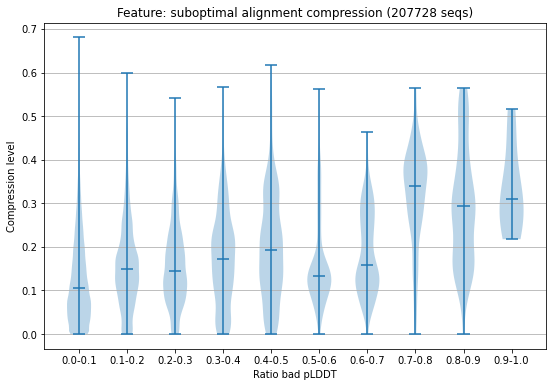

In [27]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(9, 6))

def violin_plot(ax, prop, title, bucket_step_size=0.1, decimals=1):
    xprop = 'ratio_bad_plddt'
    df_without_na = df.dropna(subset=[prop])
    buckets_indices = np.arange(np.floor(df_without_na[xprop].min()), df_without_na[xprop].max(), bucket_step_size)
    buckets = [df_without_na[df_without_na[xprop].between(i, i + bucket_step_size, inclusive='left')][prop].values for i in buckets_indices]
    labels = [f'{np.round(i, decimals=decimals)}-{np.round(i + bucket_step_size, decimals=decimals)}' for i in buckets_indices]
    nans = [float('nan'), float('nan')]
    ax.violinplot(dataset=[bucket if bucket.any() else nans for bucket in buckets], showmedians=True)
    ax.yaxis.grid(True)
    ax.set_xlabel('Ratio bad pLDDT')
    ax.set_ylabel(title)
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)

ax1.set_title('Feature: suboptimal alignment compression (207728 seqs)')
violin_plot(ax1, 'suboptim_compress', 'Compression level')

plt.show()

In [21]:
df_with_compression = df.dropna(subset=['suboptim_compress'])

In [22]:
worst_entries = df_with_compression.nsmallest(n=300, columns=['ratio_bad_plddt', 'median_plddt'])
best_entries = df_with_compression.nlargest(n=300, columns=['ratio_bad_plddt', 'median_plddt'])

In [23]:
worst_clusters = worst_entries['cluster_id'].value_counts()
best_clusters = best_entries['cluster_id'].value_counts()

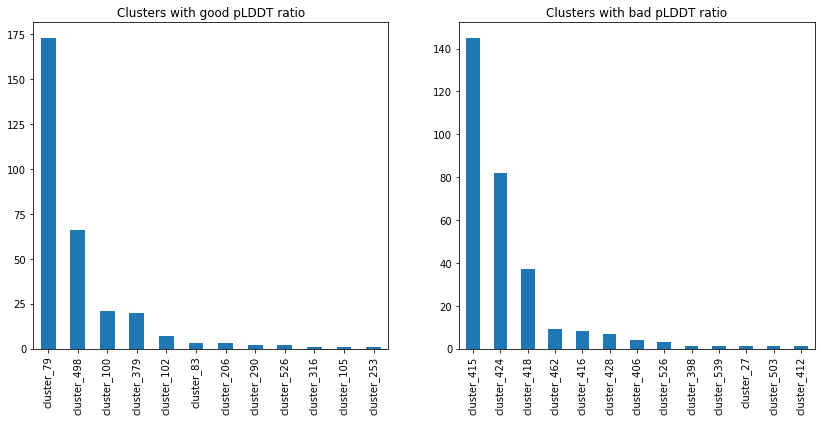

In [24]:
%matplotlib inline
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(14, 6))

best_clusters[:25].plot(kind="bar", ax=ax1)
worst_clusters[:25].plot(kind="bar", ax=ax2)

ax1.set_title('Clusters with good pLDDT ratio')
ax2.set_title('Clusters with bad pLDDT ratio')

plt.show()